In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import csv
import pickle
import matplotlib.dates as mdates
from scipy import stats
from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
roots = "D:/Dropbox/Doutorado/Jupyter/GitHub/ADCP_Shear_SSC_Rouse/Output_Data/"
file_names = ['U_fft.pkl', 'V_fft.pkl', 'U_raw.pkl', 'V_raw.pkl', 'Time_fft.pkl', 
              'Time_II_fft.pkl', 'REA.pkl', 'SSC_rea.pkl', 'depth.pkl', 'wave_T_fft.pkl',
              'wave_H_fft.pkl','wave_dir_SC.pkl','wave_dt_stamp.pkl','wave_dt.pkl']

# Dicionário para armazenar os dados já processados de velocidadee outros
data = {}

# Loop através dos nomes dos arquivos e carrega os dados usando pickle
for file_name in file_names:
    with open(roots+file_name, 'rb') as file:
        data[file_name.replace('.pkl', '')] = pickle.load(file)
        




In [5]:
z = np.array([0.90,1.40,1.90,2.40,2.90,3.40,3.90,4.40,4.90,5.40,5.90,6.40,6.90,7.40,7.90,8.40,8.90,9.40,9.90,10.40,10.90,11.40,11.90,12.40,12.90,13.40,13.90,14.40])
M = np.sqrt(data['U_fft']**2+data['V_fft']**2)
UV_dir = np.arctan2(data['V_fft']/M, data['U_fft']/M)
UV_dir_degrees = UV_dir * 180/np.pi

#inteporlando os dados de Vel., SSC_rea, e profundidade para o tempo do simcosta.
M_intp = np.stack([np.interp(data['wave_dt_stamp'], data['Time_II_fft'], M[:, j]) for j in range(len(z))], axis=1)
M_dir_intp = np.stack([np.interp(data['wave_dt_stamp'], data['Time_II_fft'], UV_dir_degrees[:, j]) for j in range(len(z))], axis=1)
ssc_intp = np.stack([np.interp(data['wave_dt_stamp'], data['Time_II_fft'], data['SSC_rea'][:, j]) for j in range(len(z))], axis=1)

niveis_intp = np.interp(data['wave_dt_stamp'], data['Time_II_fft'], data['depth'])

In [6]:
#A Referência de cada equação esta no final desse notebook.
t_m_array = []
t_mc_array = []
t_mw_array = []
t_max_array = []
wv_array = []
ucr = []
#Parâmetros de entrada
dens = 1025 #water density (kg/m3)
visc_k = 0.000001 #kinematic viscosity (m2/s)1e-06
sed_size = 0 # 0 é para fundo com leito suave
gv = 9.80665
for i in range(len(data['wave_dt_stamp'])):
    #Calcular a vel. orbital de onda
    TN_T = np.sqrt( niveis_intp[i]/(gv*(data['wave_T_fft'][i]**2))) #(A1)
    if TN_T<0.2:
        #(A2)
        wv = (0.5*data['wave_H_fft'][i]*np.sqrt(gv/niveis_intp[i])*(1-(1/3*(( 2*np.pi*np.sqrt( niveis_intp[i]/(gv*(data['wave_T_fft'][i]**2))) )**2))))# equation (18)
    if TN_T>=0.2:
        #(A3)
        wv = (data['wave_H_fft'][i]/2)*np.sqrt(gv/niveis_intp[i])*np.exp( (  ( (4.41/data['wave_T_fft'][i])*np.sqrt(niveis_intp[i]/gv)  )**2.45)*-1 )# equation (22)
    wv_array.append(wv)
    vel_m = np.nanmean(M_intp[i, :], 0) #Vel. integrada na profundidade (m/s)
    dir_WV = np.rad2deg(data['wave_dir_SC'][i]) - np.nanmean(M_dir_intp[i,:]) #Diferença angular entre a direção de corrente e onda (graus)
    dir_WV_rad = np.deg2rad(dir_WV) #converter para radianos
    #Calculando os parâmetros básicos
    if sed_size>0:
        ks = sed_size/12 #fundo rugoso - (A4)
    re_v = (vel_m*niveis_intp[i])/visc_k #Número de Reynolds para corrente (A7)
    A_wv = wv*data['wave_T_fft'][i]/6.283185307179586 #wave semi-orbital excursion (A8)
    re_w = (wv*A_wv)/visc_k #Número de Reynolds para onda (A9)
    cds = 0.0001615*(np.exp(6*(re_v**-0.08))) #drag coefficient for current for smooth turbulent flow (A10)
    fws = 0.0521*(re_w**-0.187)#wave friction factor for smooth turbulent flow (A11)
    u_xe = ((cds**2)*(vel_m**4)+(fws/2)**2*(wv**4))**0.25 # (A6)
    if sed_size==0:
        ks = visc_k/(9*u_xe)#fundo liso - #(A5)
    cdr = (0.4/(np.log(niveis_intp[i]/ks)-1))**2 #drag coefficient for current for rough turbulent flow (A12)
    fwr = 1.39*(A_wv/ks)**-0.52 #wave frictionn factor for rought turbulent flow (A13)
    #Parte 1 - Current only
    if re_v <= 2000: #laminar flow
        t_c = (3*dens*visc_k*vel_m)/niveis_intp[i]# (A14)
        t_mc_array.append(t_c)
    if re_v > 2000:  #turbulent flow
        t_cs = dens*cds*(vel_m**2)# (A15)
        t_cr = dens*cdr*(vel_m**2)# (A16)
        if t_cs > t_cr:
            t_c = t_cs 
        if t_cr > t_cs:
            t_c = t_cr
        t_mc_array.append(t_c)        
    #Parte 2 - Wave only  
    if re_w <= 150000: #laminar flow
        t_w = dens*(re_w**-0.5)*(wv**2)# (A18)
        t_mw_array.append(t_w)
    if re_w > 150000: #rough flow
        t_ws = (dens*fws*(wv**2))/2# (A19)
        t_wr = (dens*fwr*(wv**2))/2# (A20)
        if t_ws > t_wr:
            t_w = t_wr
        else:
            t_w = t_ws
        t_mw_array.append(t_w)
    #Parte 3 - Combined wave and current flow
    if vel_m>0 and wv>0:
        Cre_v = 2000+(592000*re_w)**0.35
        Cre_w = 150000
        if re_v > Cre_v or re_w>Cre_w:
            #rough turbulent wave-plus-current shear-stress
            ar = 0.24
            T_I = [0,12]# (A22)
            T_I[0] = ar*((fwr/2)**0.5)*(A_wv/ks)# (A22)
            T_I = np.max(T_I)# (A22)
            T_II = niveis_intp[i]/(T_I*ks)# (A23)
            T_III = ((cdr**2)+((fwr/2)**2)*((wv/vel_m)**4))**0.25# (A24)
            A_I = (T_III*(np.log(T_II)-1))/(2*np.log(T_I))# (A25)
            A_II = 0.4*T_III/np.log(T_I)# (A26)
            Cdm = ((np.sqrt(A_I**2+A_II) - A_I)**2)# (A27)
            #(A28)
            Cdm_max = np.sqrt((Cdm+(T_III*(wv/vel_m)*np.sqrt(fwr/2)*np.cos(dir_WV_rad)))**2 + (T_III*(wv/vel_m)*np.sqrt(fwr/2)*np.sin(dir_WV_rad))**2)#(A26)
            t_mc = dens*Cdm*(vel_m**2)# (A32)
            t_maxc = dens*Cdm_max*(vel_m**2)# (A33)
            #smooth turbulent wave-plus-current shear-stress
            T_I = 9*ar*re_w*np.sqrt(fws/2)*(((cds**2)*(vel_m/wv)**4+(fws/2)**2)**0.25)# (A29)
            T_II = (re_v/re_w)*(wv/vel_m)*(1/ar)*np.sqrt(2/fws)# (A30)
            T_III = ((cds**2)+(fws/2)**2*(wv/vel_m)**4)**0.25# (A31)
            A_I = (T_III*(np.log(T_II)-1))/(2*np.log(T_I))# (A25)
            A_II = 0.4*T_III/np.log(T_I)# (A26)
            Cdm = ((np.sqrt(A_I**2+A_II) - A_I)**2)# (A27)
            #(A28)
            Cdm_max = np.sqrt((Cdm+(T_III*(wv/vel_m)*np.sqrt(fws/2)*np.cos(dir_WV_rad)))**2 + (T_III*(wv/vel_m)*np.sqrt(fws/2)*np.sin(dir_WV_rad))**2)
            t_mw = dens*Cdm*(vel_m**2)# (A32)
            t_maxw = dens*Cdm_max*(vel_m**2)# (A33)
            if t_maxc > t_maxw:
                t_m = t_mc
                t_max = t_maxc
            if t_maxc < t_maxw:
                t_m = t_mw
                t_max = t_maxw
            ucr.append(np.sqrt(t_m/dens))# (A34)
            t_m_array.append(t_m)
            t_max_array.append(t_max)
        if re_v <Cre_v and re_w<Cre_w:
            print('Fluxo é laminar')            
    else:
        print("erro")

(0.0, 0.6)

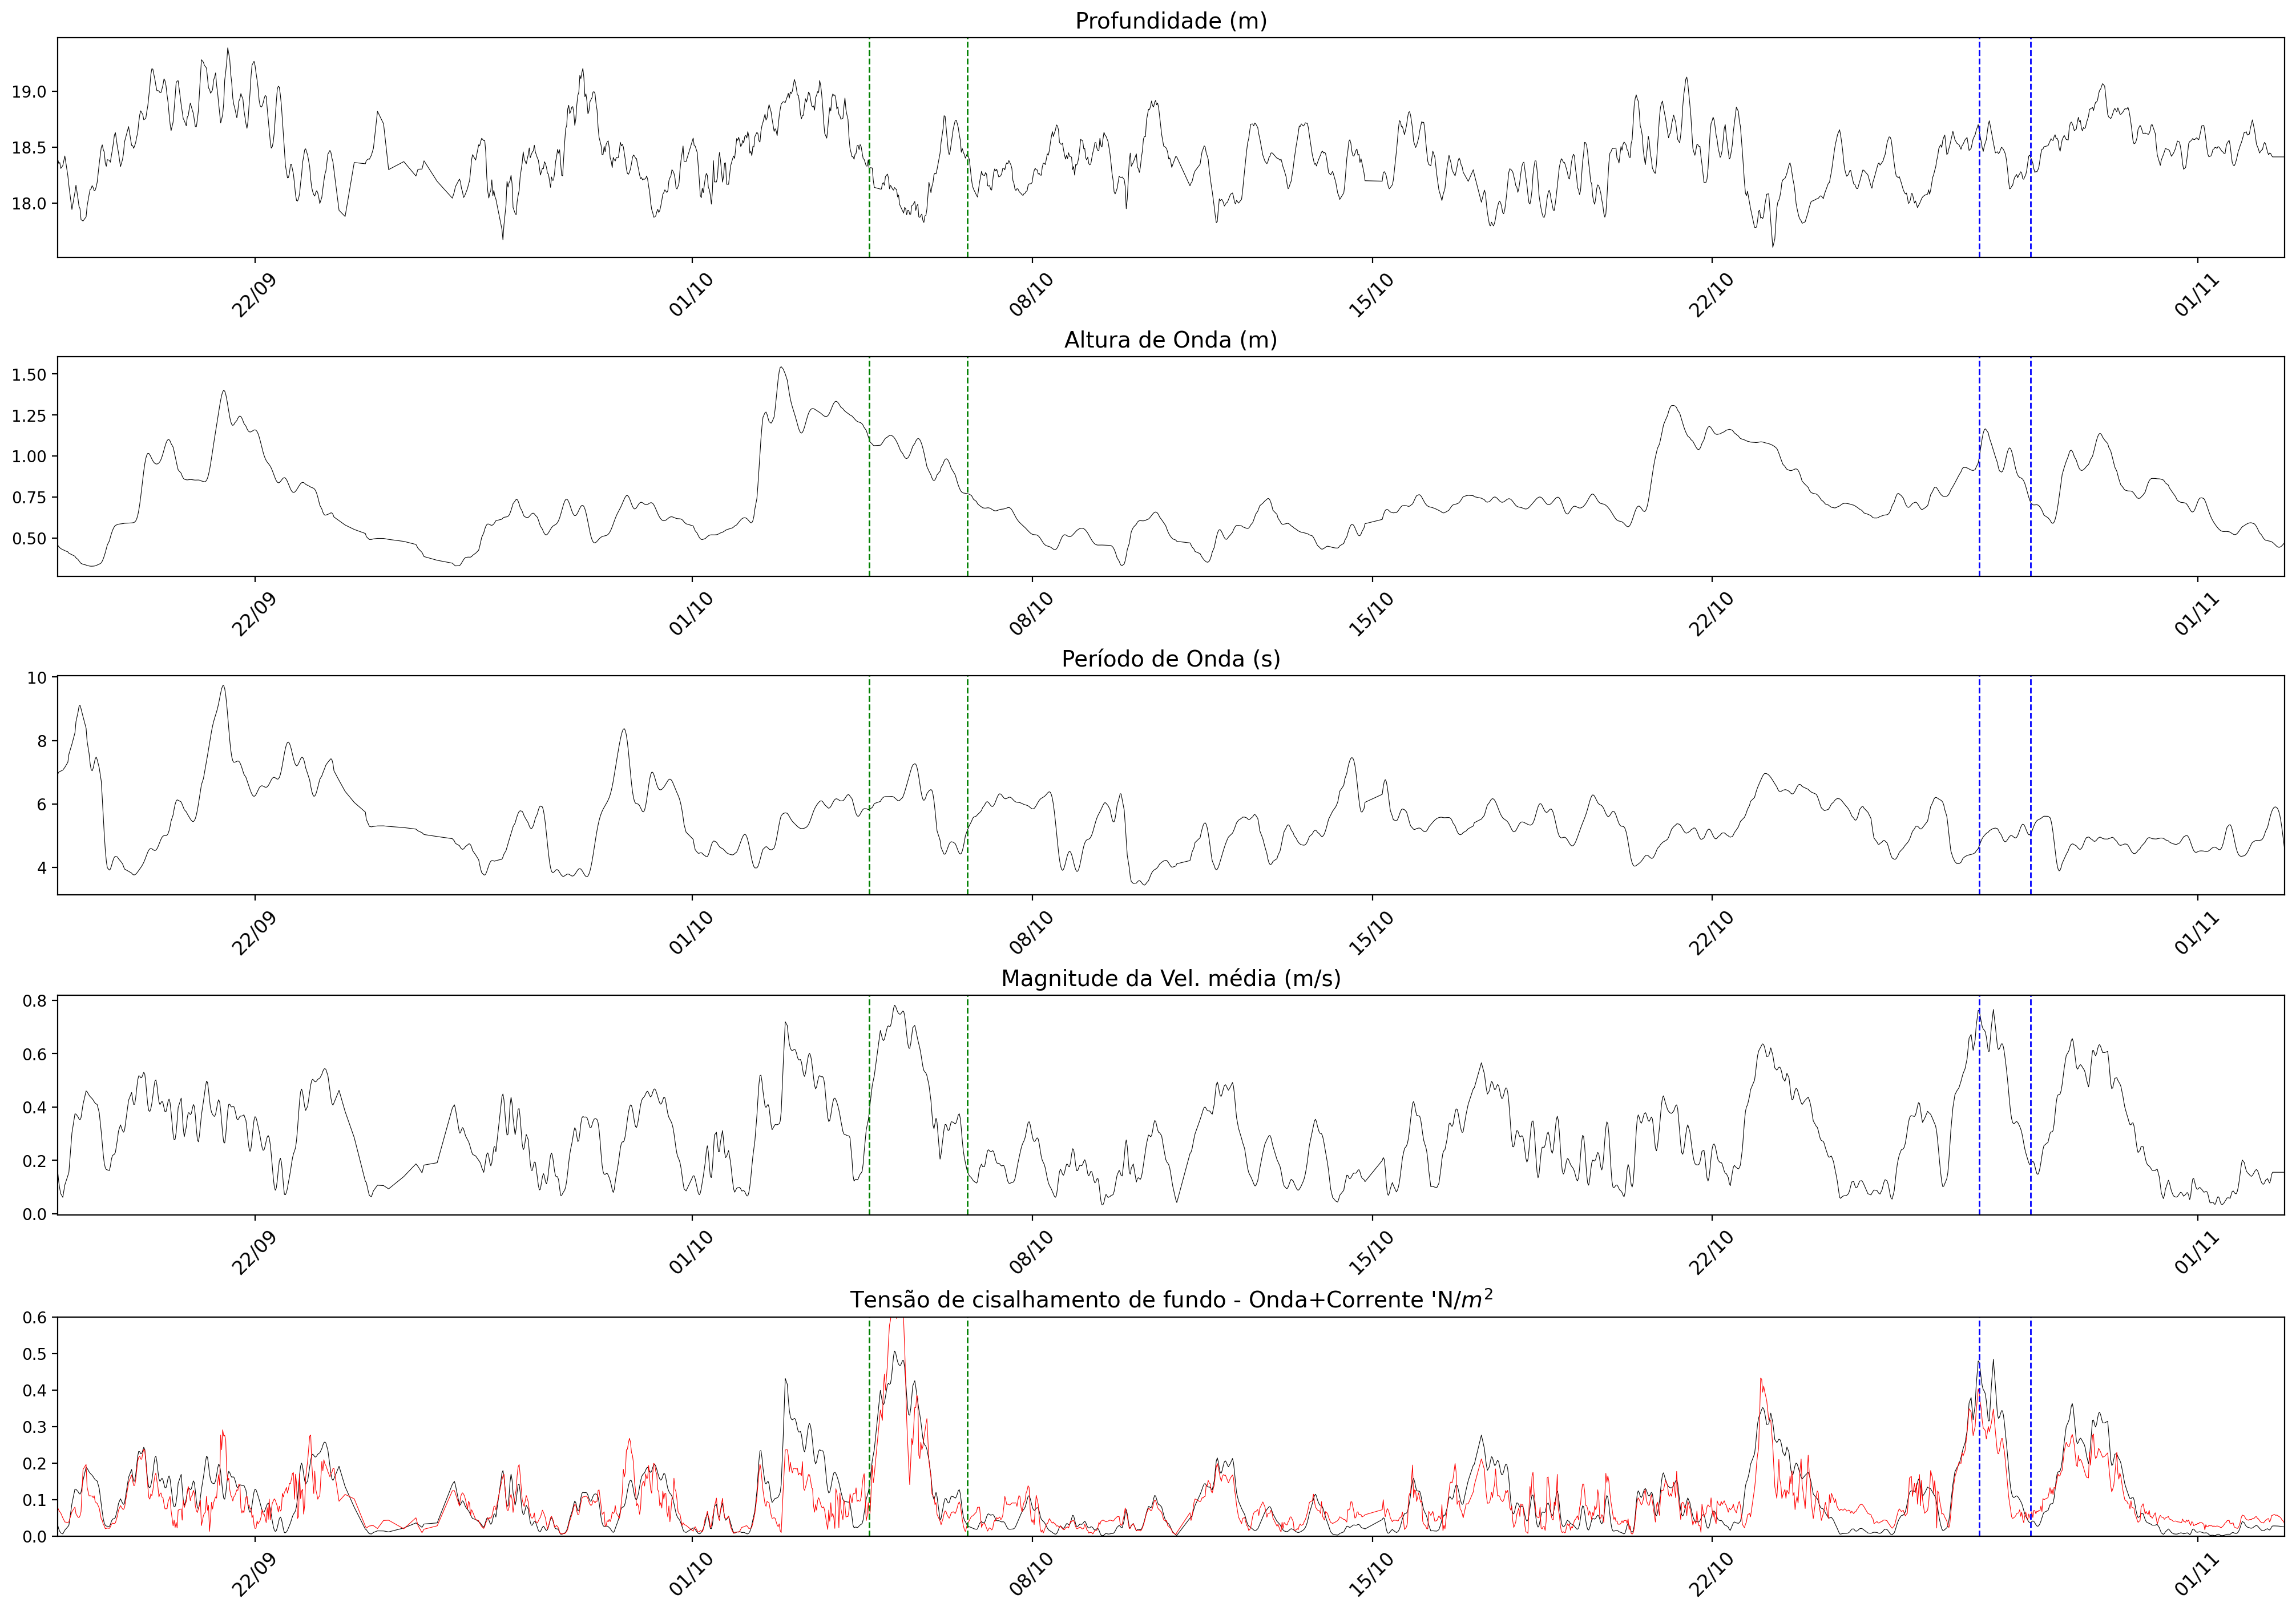

In [11]:
mag = np.nanmean(M_intp,1)

fig, ax = plt.subplots(5,1,figsize=(20, 14), dpi = 200, constrained_layout = True)

ax[0].set_title("Profundidade (m)", fontsize = 14)
ax[0].plot(data['wave_dt'], niveis_intp, linewidth=0.4, color = 'k')
ax[1].set_title("Altura de Onda (m)", fontsize = 14)
ax[1].plot(data['wave_dt'],data['wave_H_fft'], linewidth=0.4, color = 'k')
ax[2].set_title("Período de Onda (s)", fontsize = 14)
ax[2].plot(data['wave_dt'],data['wave_T_fft'], linewidth=0.4, color = 'k')
ax[3].set_title("Magnitude da Vel. média (m/s)", fontsize = 14)
ax[3].plot(data['wave_dt'],mag, linewidth=0.4, color = 'k')
ax[4].set_title("Tensão de cisalhamento de fundo - Onda+Corrente '$\mathrm{N} / m^2$", fontsize = 14)
ax[4].plot(data['wave_dt'],t_m_array, linewidth=0.4, color = 'k')


myFmt = mdates.DateFormatter('%d/%m')
for i in range(5):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].axvline(x=data['wave_dt'][620], linewidth=1, color='g', linestyle='--')
    ax[i].axvline(x=data['wave_dt'][700], linewidth=1, color='g', linestyle='--')
    ax[i].axvline(x=data['wave_dt'][1506], linewidth=1, color='b', linestyle='--')
    ax[i].axvline(x=data['wave_dt'][1551], linewidth=1, color='b', linestyle='--')

    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(data['wave_dt'][0],data['wave_dt'][-1])    
    ax[i].set_xticklabels([], rotation = 45 ,fontsize = 12)
    ax[i].xaxis.set_major_formatter(myFmt)
    
ax[4].set_ylim(0, 0.6)


#plt.savefig('soulsby_parametros.tif')


In [8]:
dens = 1025 #water density (kg/m3)
visc = 1e-3
C_test = np.zeros((len(data['wave_dt']), len(z)))
C_eo_test = np.zeros((len(data['wave_dt']), len(z)))
C_R = np.zeros(len(data['wave_dt']))+1
C_sed = np.zeros(len(data['wave_dt']))
C_con = np.zeros(len(data['wave_dt']))
C = np.zeros((len(data['wave_dt']), len(z)))
C_eo = np.zeros((len(data['wave_dt']), len(z)))

sed_range = np.arange(0.02,0.065, 0.001)
#Valores de densidade retirados desse artigo: https://link.springer.com/article/10.1007/s10236-009-0251-0
#colocar densidade como variavel ou fixo? testar depois o resultado
trash_sed = np.arange(0.02,0.26, 0.01)
np.shape(trash_sed)
trash_dens = np.array([2600,2600,2500,2400,2300,2200,2100,2000,1950,1900,1850,1800,1750,1700,1650,1600,1550,1500,1450,1400,1350,1300,1250,1200])
np.shape(trash_dens)
#interpolando os valores de densidade para o meu intervalo de tamanho de floco
dens_range = np.interp(sed_range, trash_sed, trash_dens)
aa = np.arange(0.01,1.01, 0.01)
bb = np.arange(0.2,10.1, 0.1)
cc = np.arange(11,61, 1)
conc_range = np.concatenate((aa,bb,cc))
del aa,bb,cc,trash_sed,trash_dens

#Note que para calcular z_r o tamanho de sedimento usado para estimar Ks não é o mesmo do utilizado na suspensão.
#O valor de D50 foi definido a partir do artigo: 10.5088/atl.2011.33.2.123
value = 0
k = 0.41
B = 1
for i in range(len(data['wave_dt'])):
        for cc in range(len(conc_range)):
            for ss in range(len(sed_range)):
                sed_size = sed_range[ss]/1000  #median grain diamenter (m)
                #vel. de decantação
                ws = 2/9*(dens_range[ss]-dens)/visc*gv*sed_size**2# (A38)
                c_ref = conc_range[cc]
                RO = B*ws/(k*ucr[i])# (A39)
                z_r = (26*(2*0.150/1000))/k# (A37)
                C_eo_test[i,:] = k*ucr[i]*z_r# (A36)
                C_test[i,:] = c_ref*(1 + (k*ucr[i]*z/C_eo_test[i,:]))**-RO# (A40)
                cod1 =(np.sum((C_test[i,:] - ssc_intp[i,:]/1000)**2)/28)**0.5 #RMSE
                if cod1 < C_R[i]:
                    C_R[i] = cod1
                    C_eo[i,:] = C_eo_test[i,:]
                    C_sed[i] = sed_range[ss]
                    C_con[i] = conc_range[cc]                
                    C[i,:] = C_test[i,:]
        print('time: '+str(i)+'/'+str(len(data['wave_dt']))+' RMSE: '+str(round(C_R[i]*100,2))+' eo: '+str(round(C_eo[i,0]*10000,2))+' sed_size: '+str(round(C_sed[i],3))+' Co: '+str(round(C_con[i],2)), end='\r')      
 


In [10]:
roots = "D:/Dropbox/Doutorado/Jupyter/GitHub/ADCP_Shear_SSC_Rouse/Output_Data/"
with open(roots+'t_m_fft.pkl', 'wb') as file:
    pickle.dump(t_m_array, file)
    
with open(roots+'t_max_fft.pkl', 'wb') as file:
    pickle.dump(t_max_array, file)
    
with open(roots+'ucr_fft.pkl', 'wb') as file:
    pickle.dump(ucr, file)

with open(roots+'C_R.pkl', 'wb') as file:
    pickle.dump(C_R, file)
    
with open(roots+'C_eo.pkl', 'wb') as file:
    pickle.dump(C_eo, file)
    
with open(roots+'C_sed.pkl', 'wb') as file:
    pickle.dump(C_sed, file)

with open(roots+'C_con.pkl', 'wb') as file:
    pickle.dump(C_con, file)
    
with open(roots+'ssc_rouse.pkl', 'wb') as file:
    pickle.dump(C, file)


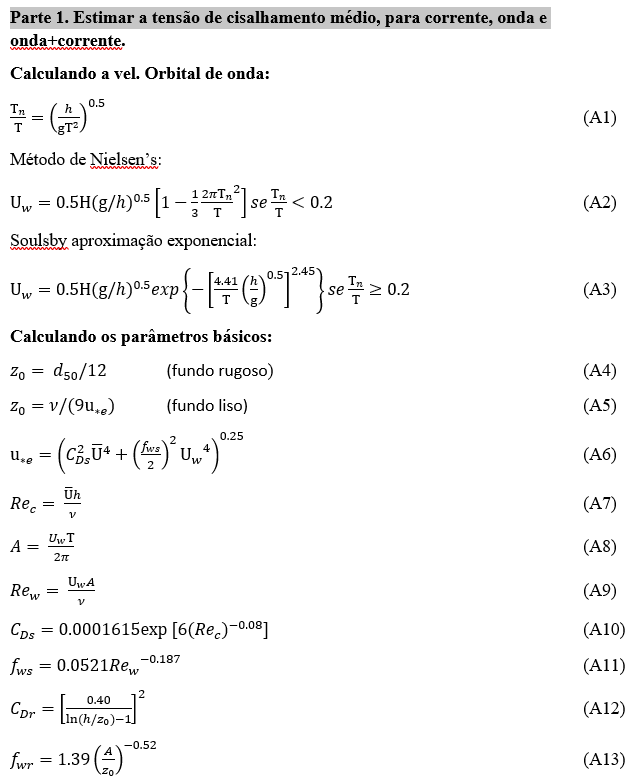

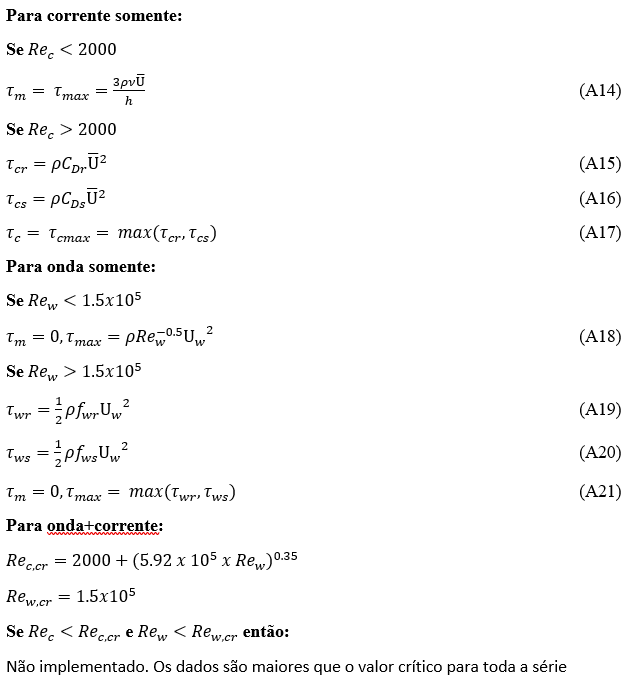


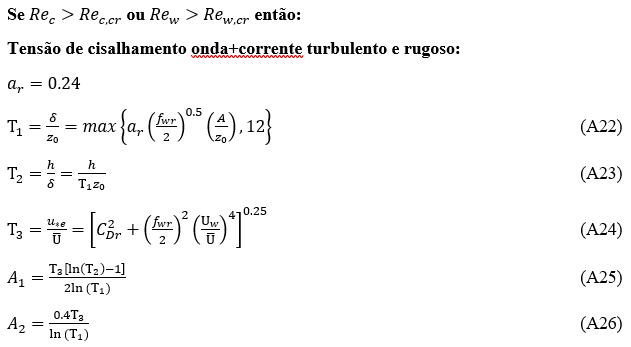

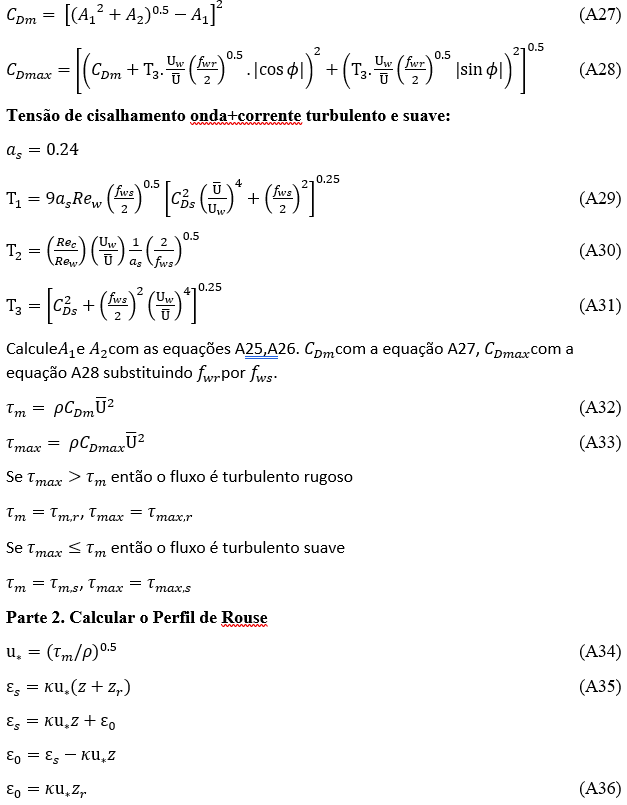

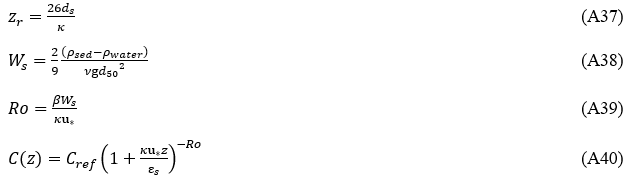

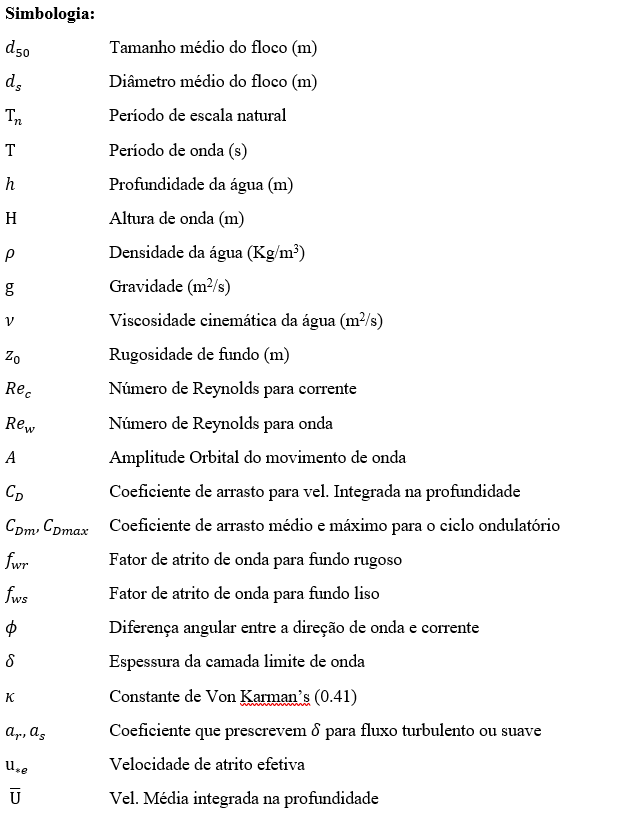

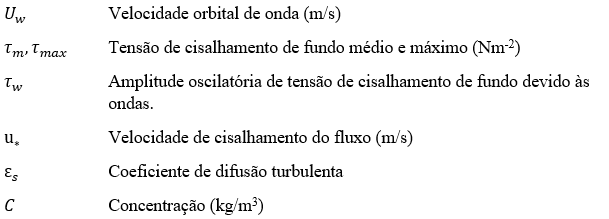